In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
import random 
random.seed(313379)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'bursi.pos.gspan'

In [15]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=800)

from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
sampler=GraphLearnSampler(radius_list=[0,1], thickness_list=[1],
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(5))
#take nu% of data as outlier
sampler.fit(training_graphs, nu=0.2, n_jobs=-1)

print('graph grammar stats:')
interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))

graph grammar stats:
#interfaces: 140   #cores: 125   #core-interface-pairs: 796
CPU times: user 28.2 s, sys: 3.37 s, total: 31.6 s
Wall time: 48 s


In [16]:
%%time
# graph sampling
graphs = get_graphs(dataset_fname, size=100)
id_start=60
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)

# sample
from graphlearn.graphlearn import GraphLearnSampler
graphs = sampler.sample(graphs,
                        n_steps=8, n_samples=4,
                        target_orig_cip=True,
                        probabilistic_core_choice=False,
                        score_core_choice= True,
                        max_core_size_diff=0,
                        improving_threshold=0.5, accept_static_penalty=0,
                        n_jobs=1,burnin=0,select_cip_max_tries=200,keep_duplicates=True)

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 26 µs


Graph id: 60


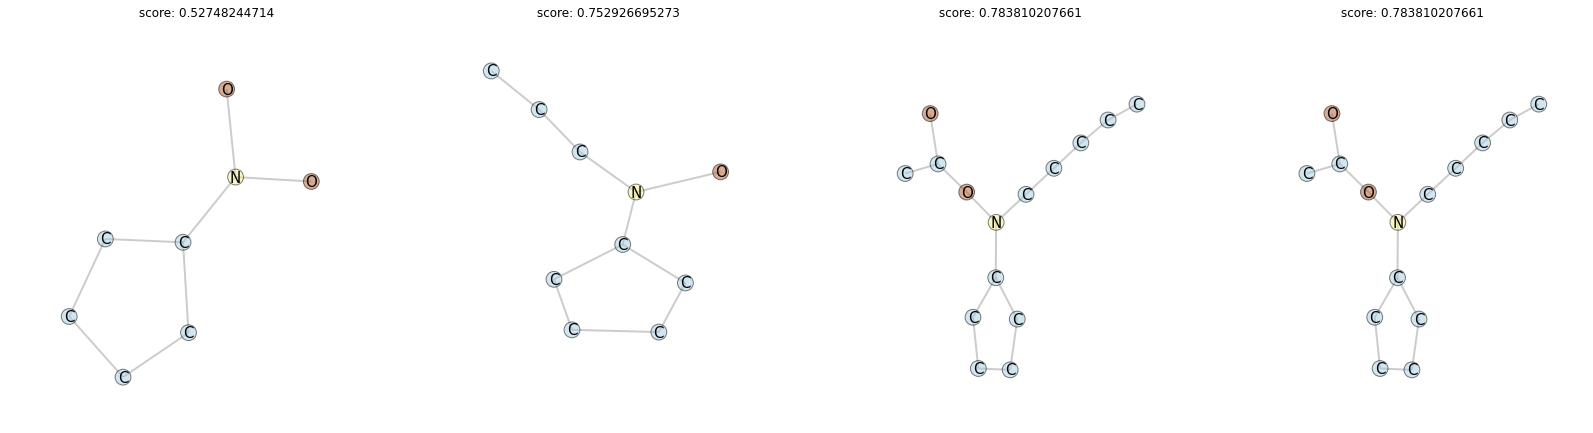

Graph id: 61


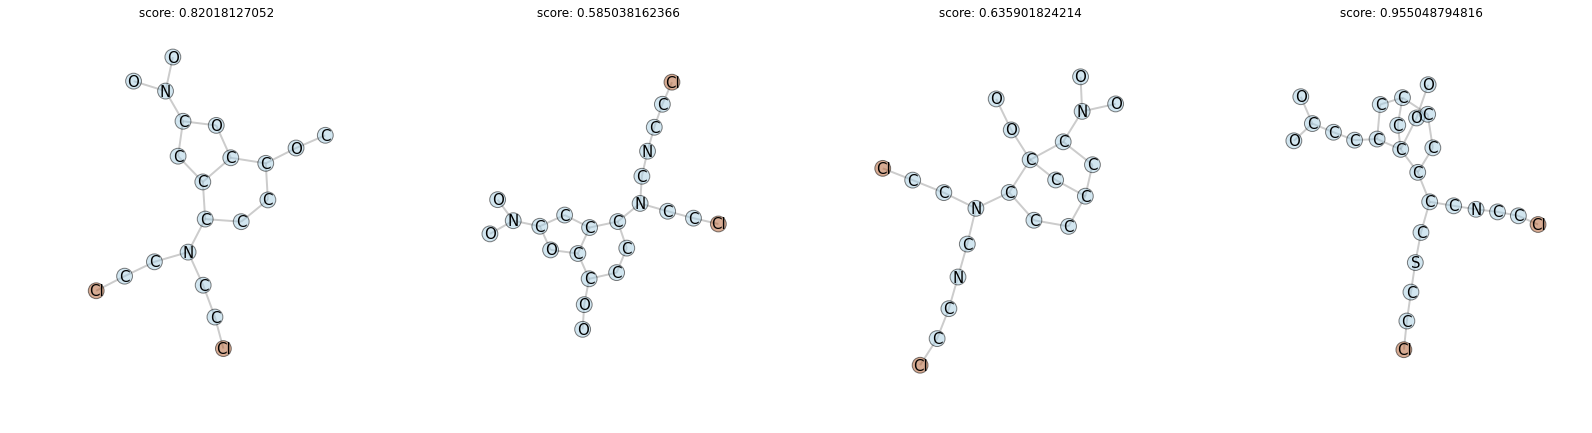

Graph id: 62


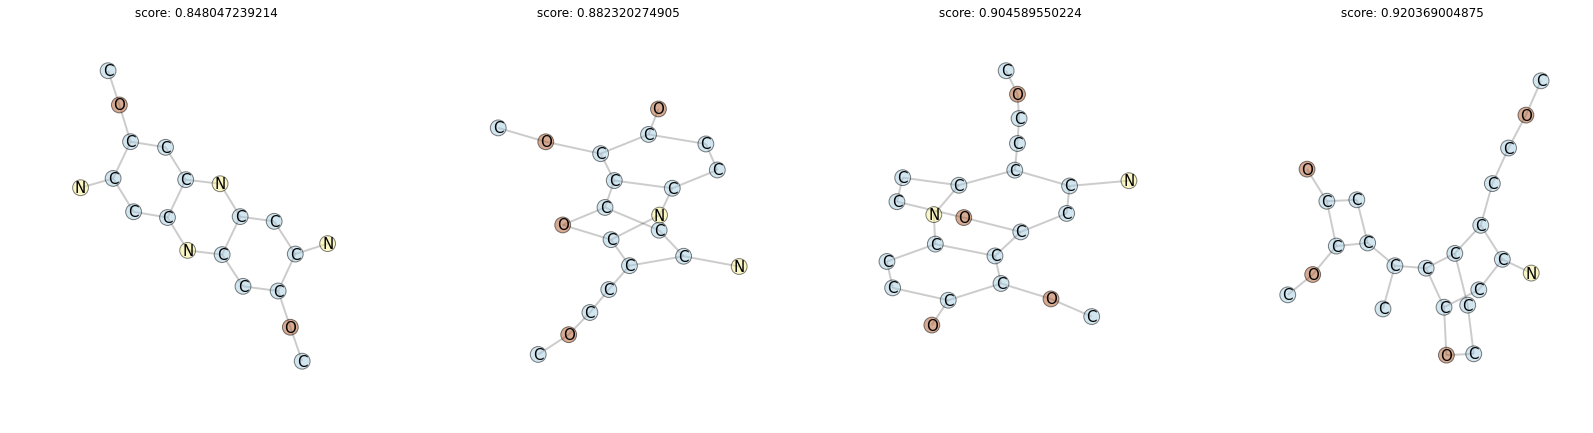

Graph id: 63


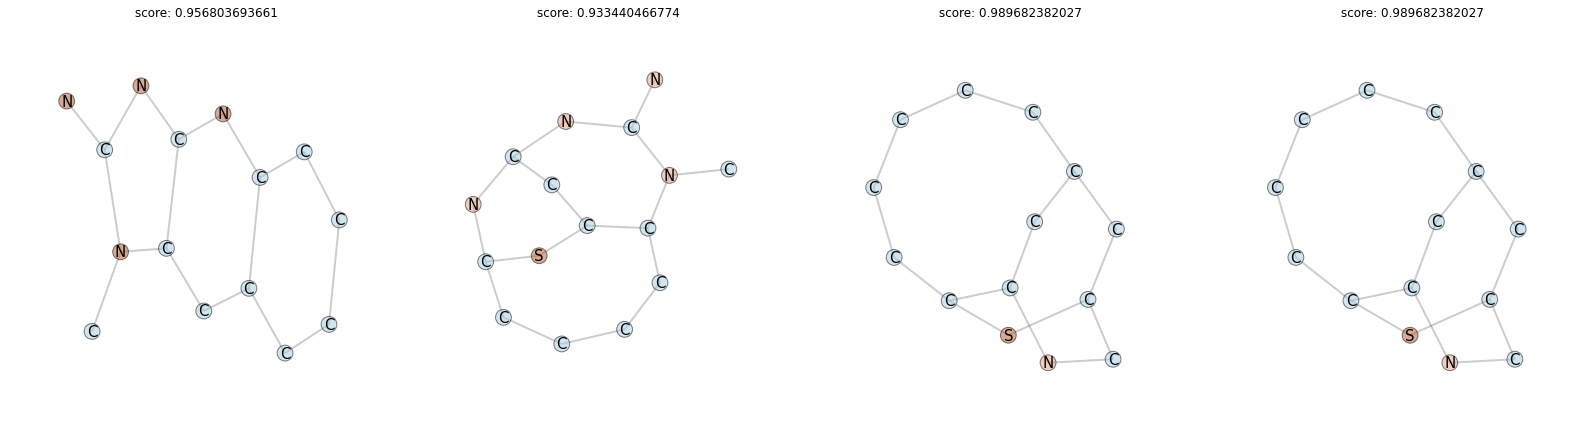

Graph id: 64


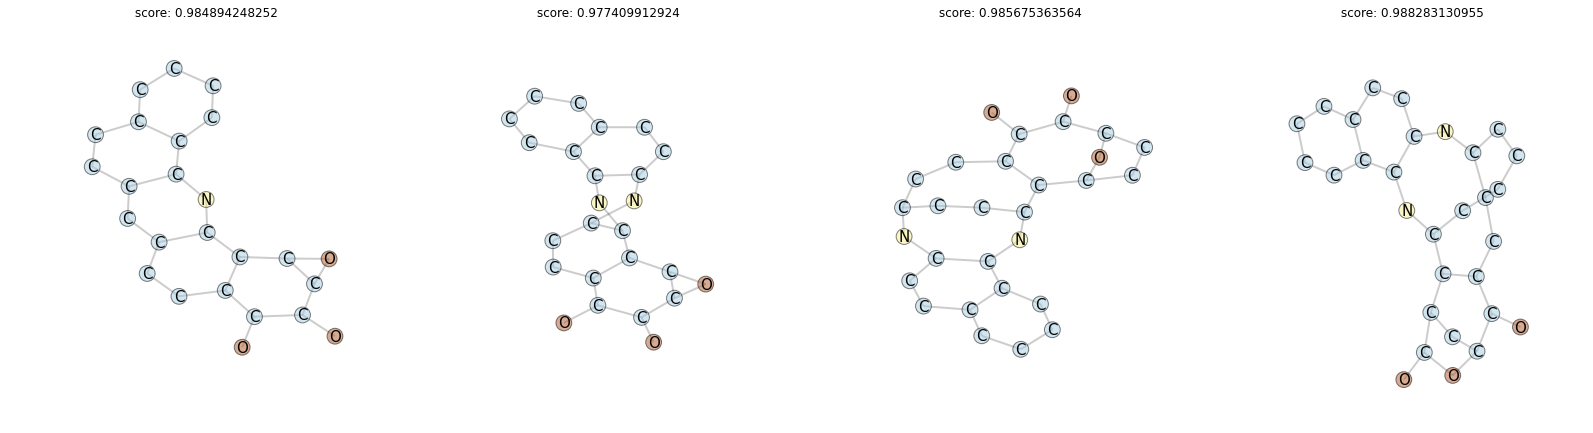

Graph id: 65


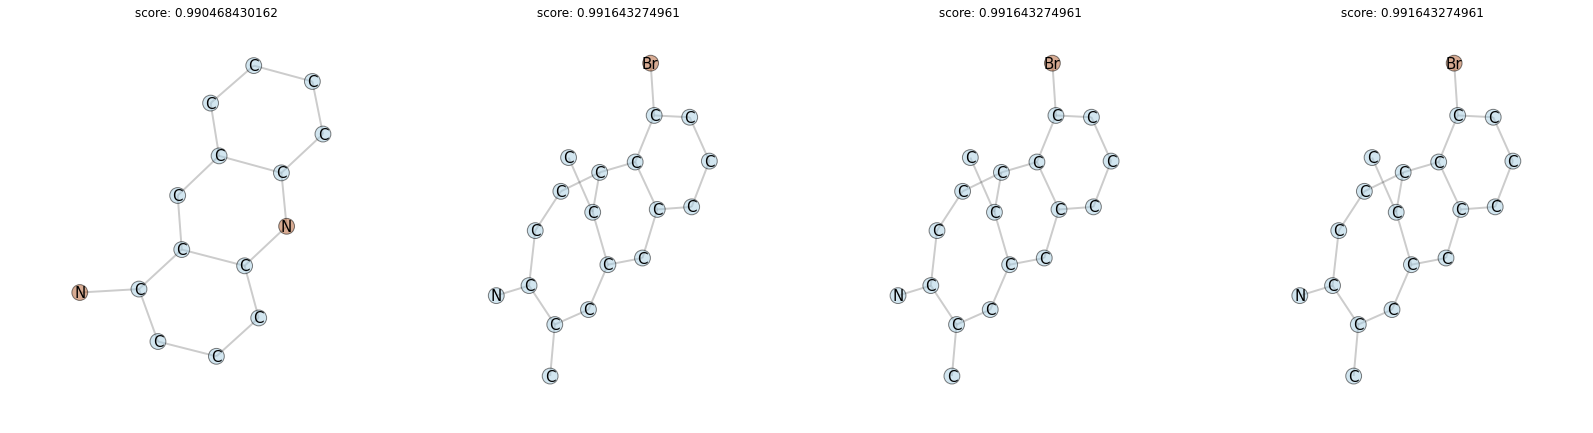

Graph id: 66


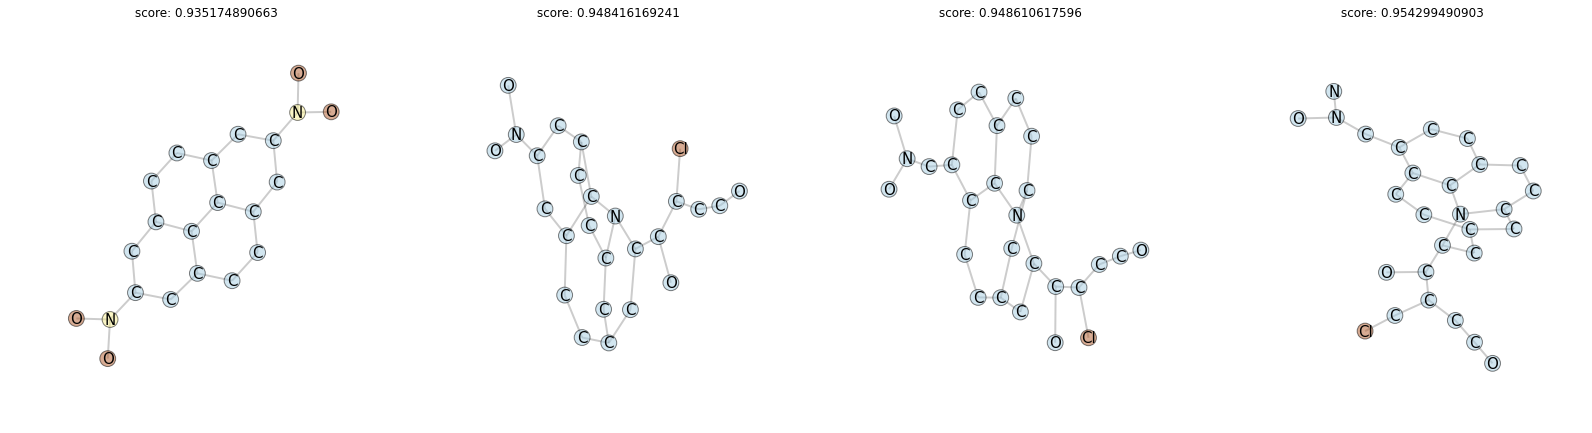

Graph id: 67


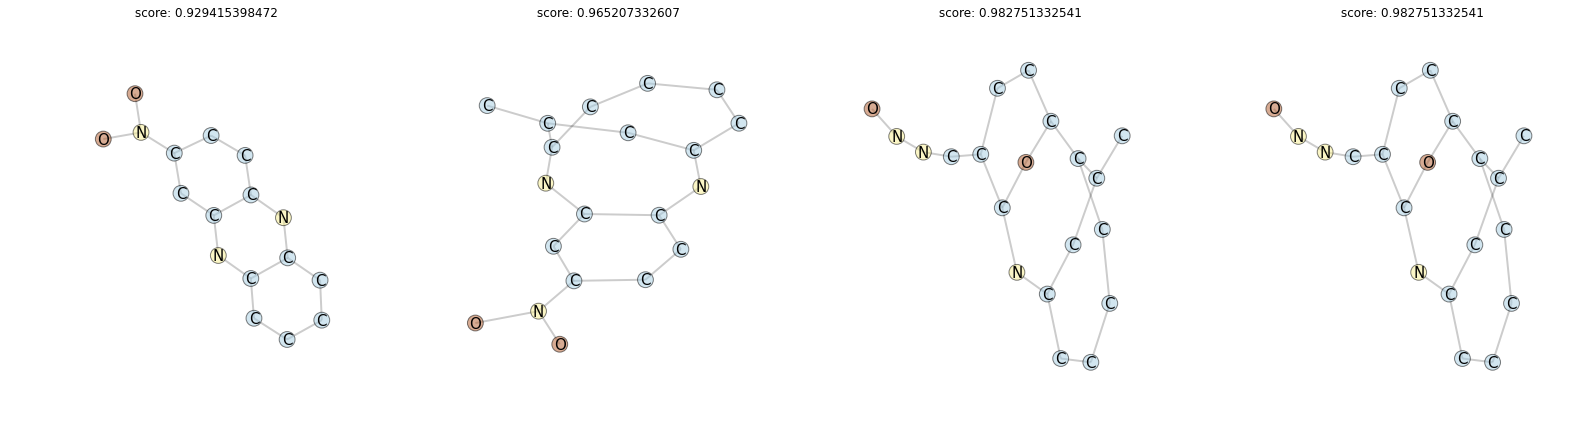

Graph id: 68


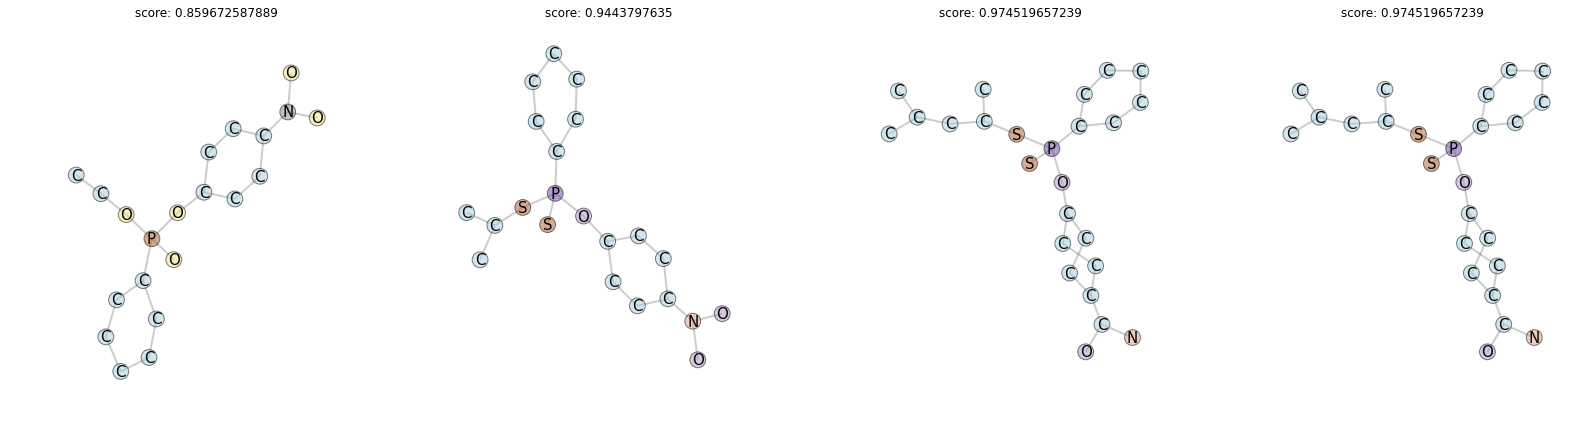

Graph id: 69


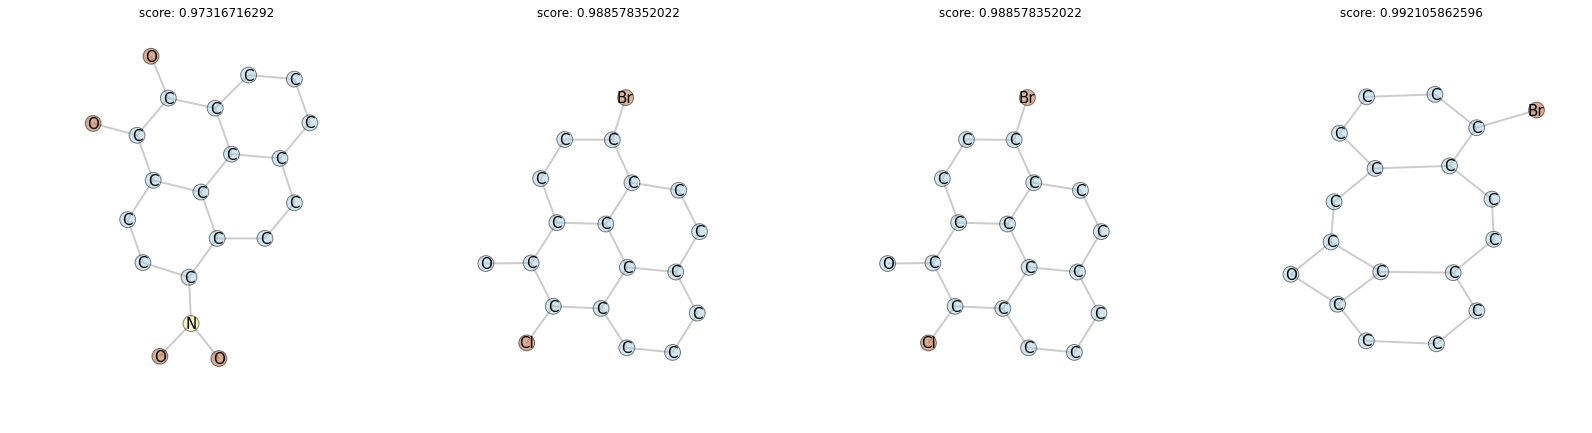

Graph id: 70


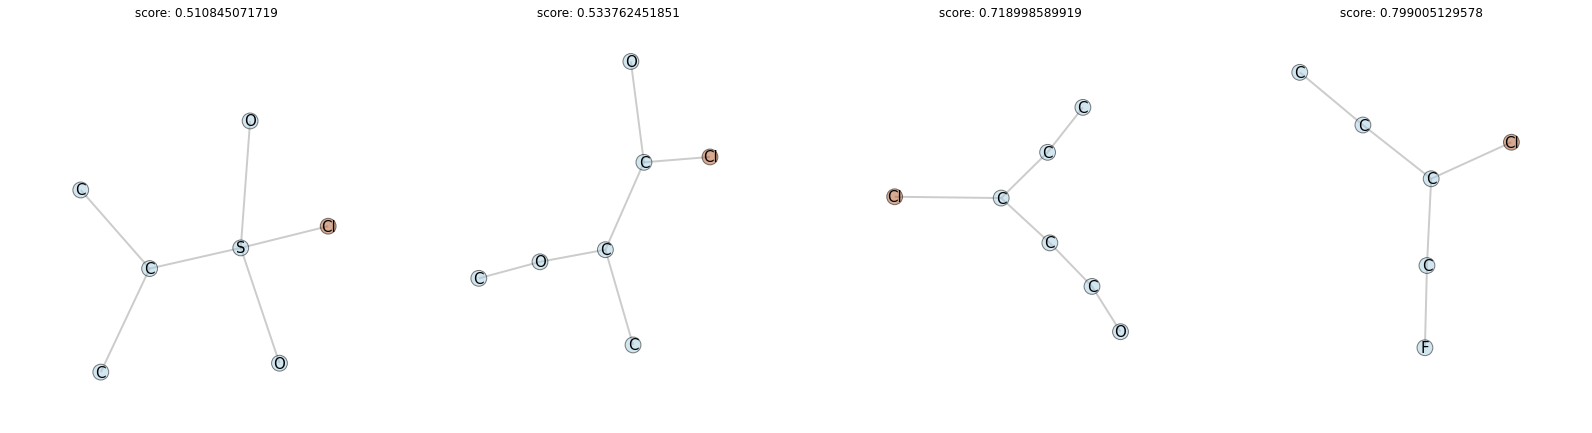

Graph id: 71


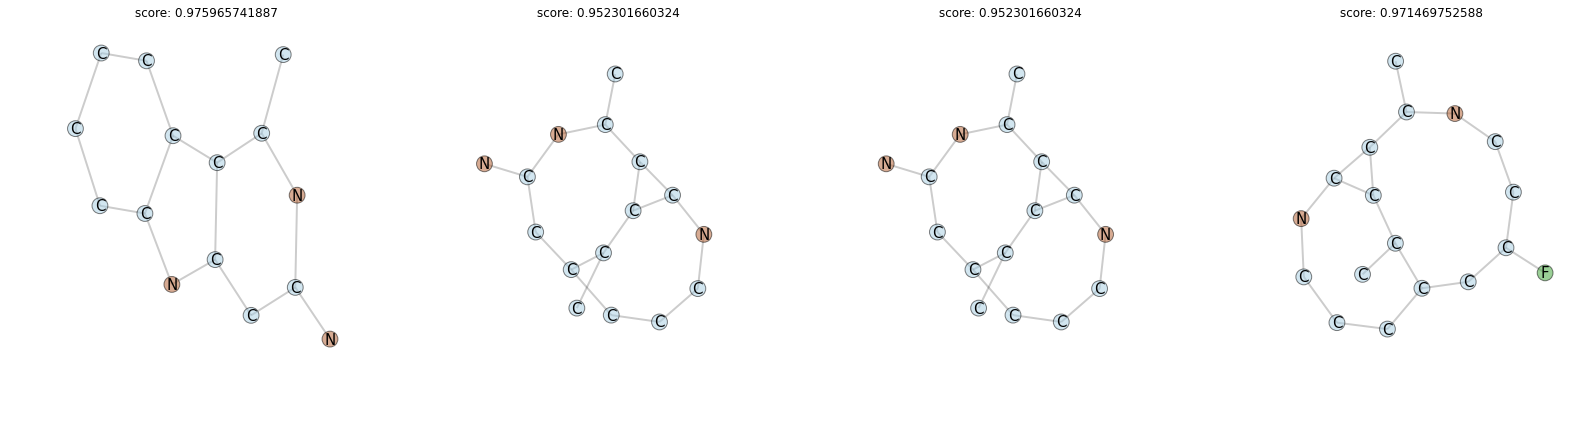

CPU times: user 29.2 s, sys: 3.01 s, total: 32.2 s
Wall time: 57.1 s


In [17]:
%%time
# plot examples of sampling paths
from graphlearn.utils.draw import  graphlearn_draw, get_score_of_graph
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    graphlearn_draw(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=250,
                   headlinehook=get_score_of_graph)

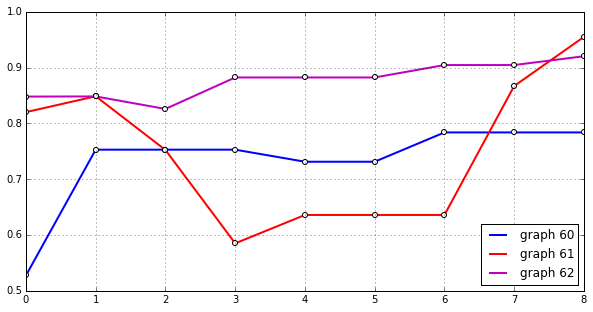

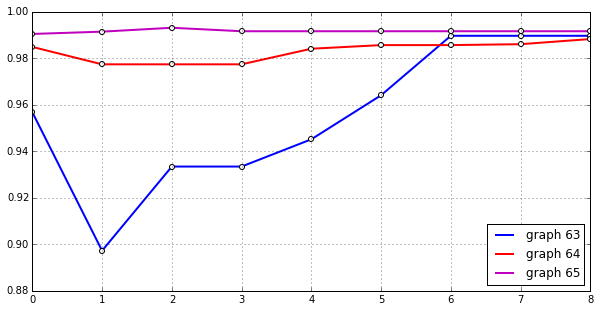

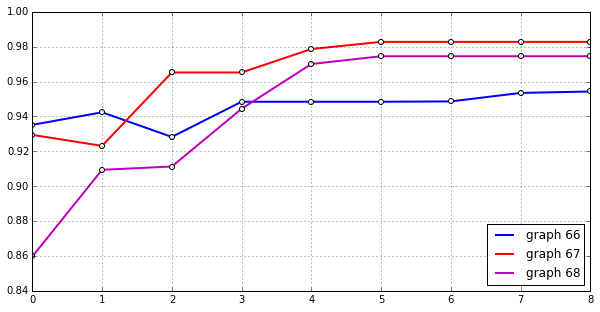

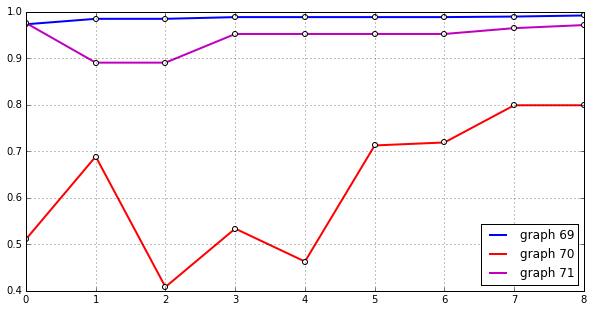

CPU times: user 992 ms, sys: 42.9 ms, total: 1.03 s
Wall time: 1.05 s


In [18]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None', markerfacecolor='white', marker='o', markeredgewidth=1,markersize=5)
    plt.legend(loc='lower right')
    plt.grid()
    #plt.ylim(-0.1,1.1)
    plt.show()

.